# _Lab 2 : ECE-GY 9163 Machine Learning for Cybersecurity_
### Submitted by: __Pratyush Shukla (ps4534)__

# Designing a backdoor detector for BadNets trained on the YouTube Face dataset using the pruning defense.

In [1]:
# All necessary imports
import os
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2

2022-12-09 23:47:02.790529: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Define function to load the data

In [2]:
# Load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

Follow instructions under [Data Section](https://github.com/csaw-hackml/CSAW-HackML-2020/tree/master/lab3#ii-data) to download the datasets.  

We will be using the clean validation data (valid.h5) from cl folder to design the defense and clean test data (test.h5 from cl folder) and  sunglasses poisoned test data (bd_test.h5 from bd folder) to evaluate the models.

In [3]:
## To-do ##
# After downloading the datasets, provide corresponding filepaths below 

clean_data_valid_filename = "data/cl/valid.h5"

clean_data_test_filename = "data/cl/test.h5"
poisoned_data_test_filename = "data/bd/bd_test.h5"

Read the data:

In [4]:
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)

cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)

Visualizing the clean test data

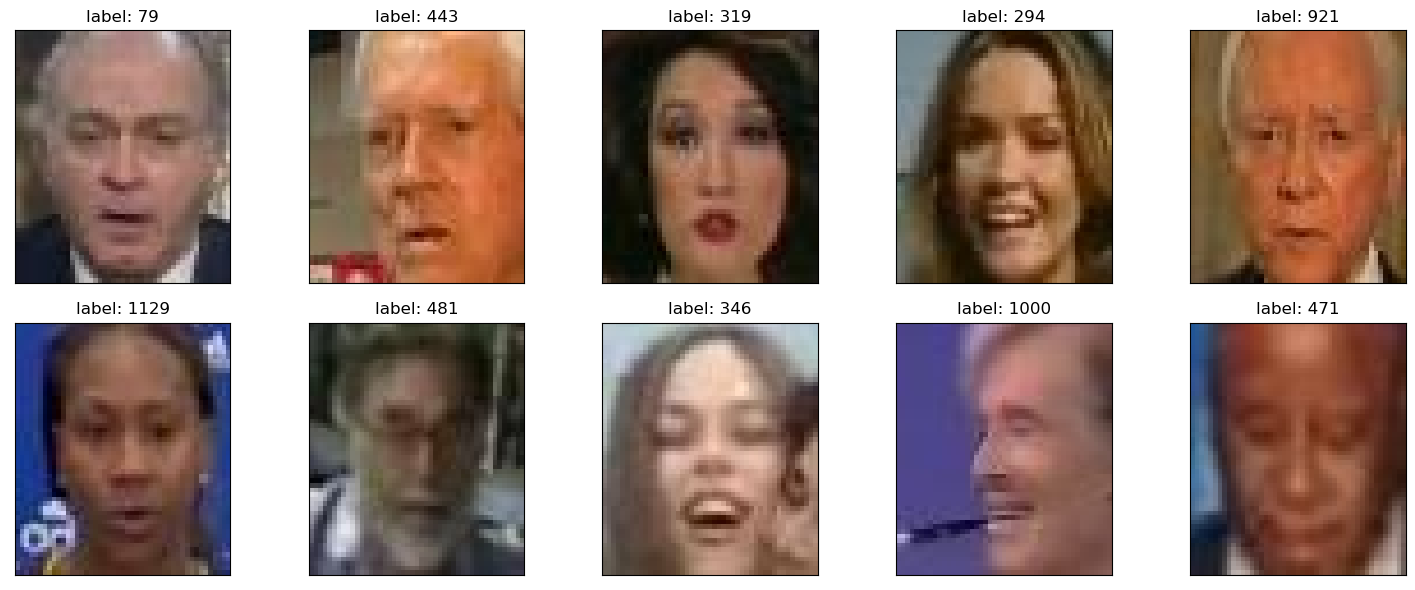

In [5]:
# Plot some images from the validation set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(cl_x_test[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(cl_y_test[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Visualizing the sunglasses poisioned test data

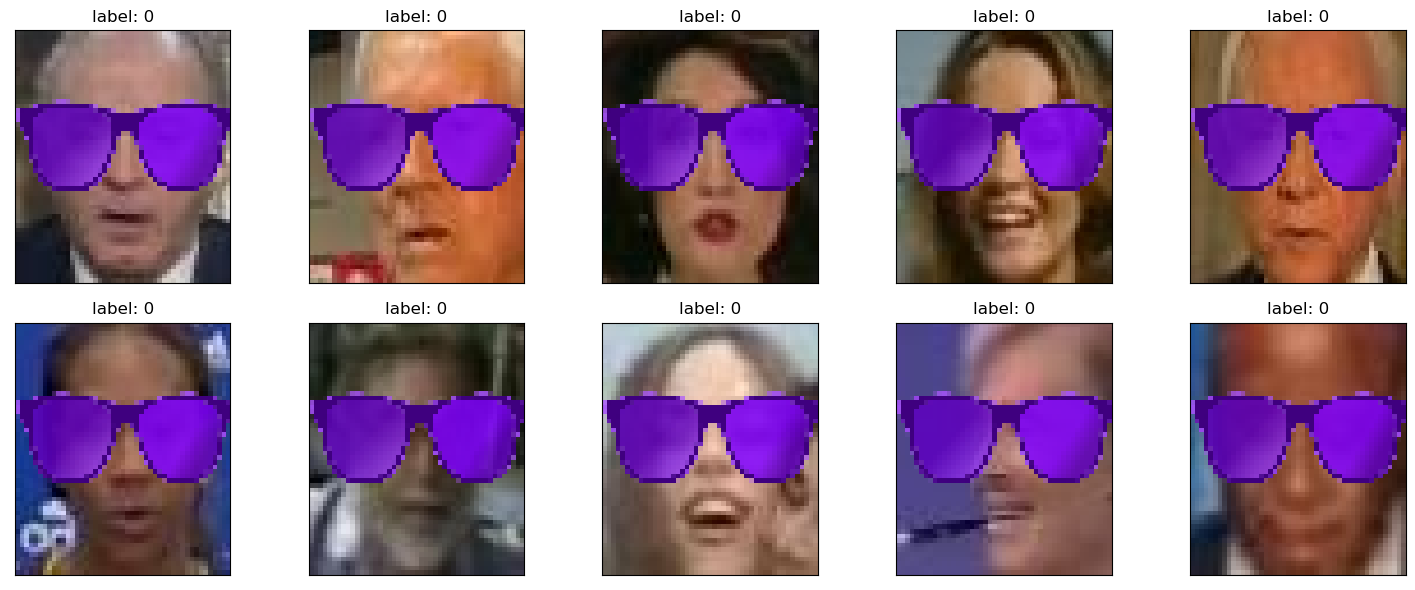

In [6]:
# Plot some images from the validation set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(bd_x_test[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(bd_y_test[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Load the backdoored model.

The backdoor model and its weights can be found [here](https://github.com/csaw-hackml/CSAW-HackML-2020/tree/master/lab3/models) 

In [7]:
## To-do ##

# First create clones of the original badnet model (by providing the model filepath below)
# The result of repairing B_clone will be B_prime

B = keras.models.load_model("models/bd_net.h5")
B.load_weights("models/bd_weights.h5")

B_clone = keras.models.load_model("models/bd_net.h5")
B_clone.load_weights("models/bd_weights.h5")

2022-12-09 23:47:15.823546: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-09 23:47:15.824584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-09 23:47:15.885793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-12-09 23:47:15.885821: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-09 23:47:16.088328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-09 23:47:16.088443: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

Output of the original badnet accuracy on the validation data:

In [8]:
# Get the original badnet model's (B) accuracy on the validation data
cl_label_p = np.argmax(B(cl_x_valid), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid)) * 100

print("Clean validation accuracy before pruning {0:3.6f}".format(clean_accuracy))
K.clear_session()

2022-12-09 23:47:18.898180: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-12-09 23:47:20.033669: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-12-09 23:47:20.169709: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-12-09 23:47:20.936502: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Clean validation accuracy before pruning 98.649000


Write code to implement pruning defense 

In [9]:
## To-do ##
c_acc = []
arate = []
save = [0,0,0]


# Redefine model to output right after the last pooling layer ("pool_3")
intermediate_model = Model(inputs=B.inputs, outputs=B.get_layer('pool_3').output)

# Get feature map for last pooling layer ("pool_3") using the clean validation data and intermediate_model
feature_maps_cl = intermediate_model.predict(cl_x_valid) 

# Get average activation value of each channel in last pooling layer ("pool_3")
averageActivationsCl = np.mean(feature_maps_cl,axis=(0,1,2))

# Store the indices of average activation values (averageActivationsCl) in increasing order
idxToPrune = np.argsort(averageActivationsCl)

# Get the conv_3 layer weights and biases from the original network that will be used for prunning
# Hint: Use the get_weights() method (https://stackoverflow.com/questions/43715047/how-do-i-get-the-weights-of-a-layer-in-keras)
lastConvLayerWeights =  B_clone.layers[5].get_weights()[0]
lastConvLayerBiases  =  B_clone.layers[5].get_weights()[1]

for chIdx in idxToPrune:

  # Prune one channel at a time
  # Hint: Replace all values in channel 'chIdx' of lastConvLayerWeights and lastConvLayerBiases with 0 
  lastConvLayerWeights[:,:,:,chIdx] = 0
  lastConvLayerBiases[chIdx] = 0

  # Update weights and biases of B_clone
  # Hint: Use the set_weights() method 
  B_clone.layers[5].set_weights([lastConvLayerWeights, lastConvLayerBiases])

  # Evaluate the updated model's (B_clone) clean validation accuracy
  cl_label_p_valid = np.argmax(B_clone(cl_x_valid), axis=1)
  clean_accuracy_valid = np.mean(np.equal(cl_label_p_valid, cl_y_valid)) * 100

  # If drop in clean_accuracy_valid is just greater (or equal to) than the desired threshold compared to clean_accuracy, then save B_clone as B_prime and break
  if (clean_accuracy-clean_accuracy_valid >= 2 and  save[0] ==0):
      print("[INFO] Accuracy dropped by 2%, saving model...")
      B_clone.save('models/model_2%.h5')
      save[0] = 1
  if (clean_accuracy-clean_accuracy_valid >= 4 and  save[1] ==0):
      print("[INFO] Accuracy dropped by 4%, saving model...")
      B_clone.save('models/model_4%.h5')
      save[1] = 1
  if (clean_accuracy-clean_accuracy_valid >= 10 and save[2] ==0):
      print("[INFO] Accuracy dropped by 10%, saving model...")
      B_clone.save('models/model_10%.h5')
      save[2] = 1
 
  c_acc.append(clean_accuracy_valid)
  bd_y_pred = np.argmax(B_clone.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_y_pred, bd_y_test))*100
  arate.append(asr)

K.clear_session()

2022-12-09 23:47:26.901930: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-09 23:47:26.915958: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


[INFO] Accuracy dropped by 2%, saving model...
[INFO] Accuracy dropped by 4%, saving model...
[INFO] Accuracy dropped by 10%, saving model...


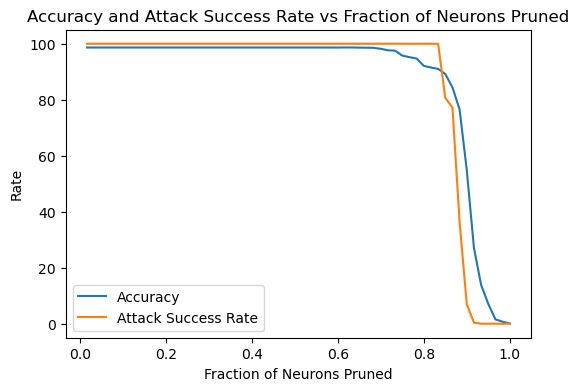

In [10]:
x_axis = np.arange(1,61)/60
plt.figure(figsize=(6, 4))
plt.plot(x_axis,c_acc)
plt.plot(x_axis,arate)
plt.legend(['Accuracy', 'Attack Success Rate'])
plt.xlabel("Fraction of Neurons Pruned")
plt.ylabel("Rate")
plt.title("Accuracy and Attack Success Rate vs Fraction of Neurons Pruned")
plt.savefig('result.png')

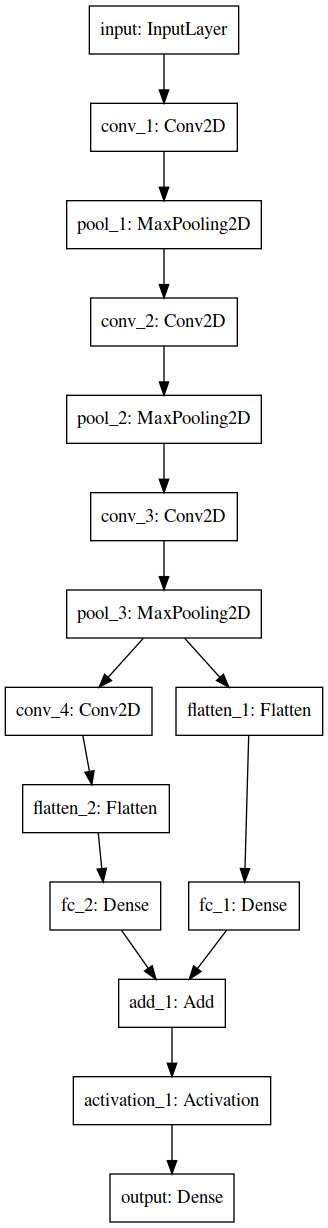

In [11]:
# Save model architecture plot
plot_model(B, to_file='model_architecture.png')

Now we need to combine the models into a repaired goodnet G  that outputs the correct class if the test input is clean and class N+1 if the input is backdoored. One way to do it is to "subclass" the models in Keras: 

In [12]:
#https://stackoverflow.com/questions/64983112/keras-vertical-ensemble-model-with-condition-in-between
class G(tf.keras.Model):
    def __init__(self, B, B_prime):
        super(G, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self,data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmpRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0],1284))
        res[np.arange(tmpRes.size),tmpRes] = 1
        return res

    # For small amount of inputs that fit in one batch, directly using call() is recommended for faster execution, 
    # e.g., model(x), or model(x, training=False) is faster then model.predict(x) and do not result in
    # memory leaks (see for more details https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)
    def call(self,data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmpRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0],1284))
        res[np.arange(tmpRes.size),tmpRes] = 1
        return res

However, Keras prevents from saving this kind of subclassed model as HDF5 file since it is not serializable. However, we still can use this architecture for model evaluation.

Load the saved B_prime model

In [13]:
B_prime_2 = keras.models.load_model("models/model_2%.h5")
B_prime_4 = keras.models.load_model("models/model_4%.h5")
B_prime_10 = keras.models.load_model("models/model_10%.h5")

Check performance of the repaired model on the test data:

In [14]:
# 2% model
cl_label_p = np.argmax(B_prime_2.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('[INFO] Clean Classification accuracy for B_prime(10):', clean_accuracy_B_prime)

bd_label_p = np.argmax(B_prime_2.predict(bd_x_test), axis=1)
asr_B_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('[INFO] Attack Success Rate for B_prime(10):', asr_B_prime)

[INFO] Clean Classification accuracy for B_prime(10): 95.90023382696803
[INFO] Attack Success Rate for B_prime(10): 100.0


In [15]:
# 4% model
cl_label_p = np.argmax(B_prime_4.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('[INFO] Clean Classification accuracy for B_prime(10):', clean_accuracy_B_prime)

bd_label_p = np.argmax(B_prime_4.predict(bd_x_test), axis=1)
asr_B_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('[INFO] Attack Success Rate for B_prime(10):', asr_B_prime)

[INFO] Clean Classification accuracy for B_prime(10): 92.29150428682775
[INFO] Attack Success Rate for B_prime(10): 99.98441153546376


In [16]:
# 10% model
cl_label_p = np.argmax(B_prime_10.predict(cl_x_test), axis=1)
clean_accuracy_B_prime = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('[INFO] Clean Classification accuracy for B_prime(10):', clean_accuracy_B_prime)

bd_label_p = np.argmax(B_prime_10.predict(bd_x_test), axis=1)
asr_B_prime = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('[INFO] Attack Success Rate for B_prime(10):', asr_B_prime)

[INFO] Clean Classification accuracy for B_prime(10): 84.54403741231489
[INFO] Attack Success Rate for B_prime(10): 77.20966484801247


Check performance of the original model on the test data:

In [17]:
cl_label_p = np.argmax(B.predict(cl_x_test), axis=1)
clean_accuracy_B = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('[INFO] Clean Classification accuracy for B:', clean_accuracy_B)

bd_label_p = np.argmax(B.predict(bd_x_test), axis=1)
asr_B = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('[INFO] Attack Success Rate for B:', asr_B)

[INFO] Clean Classification accuracy for B: 98.62042088854248
[INFO] Attack Success Rate for B: 100.0


Create repaired network

In [20]:
# Repaired network repaired_net
repaired_net_2 = G(B, B_prime_2)
repaired_net_4 = G(B, B_prime_4)
repaired_net_10 = G(B, B_prime_10)

Check the performance of the repaired_net on the test data

In [21]:
# 2% model
cl_label_p = np.argmax(repaired_net_2(cl_x_test), axis=1)
clean_accuracy_repaired_net = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('[INFO] Clean Classification accuracy for repaired net(10):', clean_accuracy_repaired_net)

bd_label_p = np.argmax(repaired_net_2(bd_x_test), axis=1)
asr_repaired_net = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('[INFO] Attack Success Rate for repaired net(10):', asr_repaired_net)

In [ ]:
# 4% model
cl_label_p = np.argmax(repaired_net_4(cl_x_test), axis=1)
clean_accuracy_repaired_net = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('[INFO] Clean Classification accuracy for repaired net(10):', clean_accuracy_repaired_net)

bd_label_p = np.argmax(repaired_net_4(bd_x_test), axis=1)
asr_repaired_net = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('[INFO] Attack Success Rate for repaired net(10):', asr_repaired_net)

[INFO] Clean Classification accuracy for repaired net(10): 92.1278254091972
[INFO] Attack Success Rate for repaired net(10): 99.98441153546376


In [ ]:
# 10% model
cl_label_p = np.argmax(repaired_net_10(cl_x_test), axis=1)
clean_accuracy_repaired_net = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('[INFO] Clean Classification accuracy for repaired net(10):', clean_accuracy_repaired_net)

bd_label_p = np.argmax(repaired_net_10(bd_x_test), axis=1)
asr_repaired_net = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('[INFO] Attack Success Rate for repaired net(10):', asr_repaired_net)

[INFO] Clean Classification accuracy for repaired net(10): 84.3335931410756
[INFO] Attack Success Rate for repaired net(10): 77.20966484801247


End of Notebook